In [1]:
using ITensors, ITensorMPS


N = 100
J = 1
h = 0.75
hb = 1.0
sites = siteinds("S=1/2",N)

os = OpSum()
for j=1:N-1
os += -J*4, "Sz",j,"Sz",j+1
end

for j=1:N
os += -2*h, "Sx",j
end

os += -2*hb, "Sz",1


H = MPO(os,sites)

nsweeps = 15 # number of sweeps is 5
maxdim = [10,20,100,100,200] # gradually increase states kept
cutoff = [1E-10] # desired truncation error

states = [isodd(n) ? "Up" : "Dn" for n in 1:N]
psi0 = MPS(sites, states)

energy,psi = dmrg(H,psi0;nsweeps,maxdim,cutoff);

sxop = OpSum()
sxop += 2,"Sz",1

Sx1 = MPO(sxop,sites);
ref_state= apply(Sx1,psi);
ev_state = copy(ref_state);




cutoff = 1E-8
tau = 0.01
ttotal = 100


# Make gates (1,2),(2,3),(3,4),...
gates = ITensor[]
for j in 1:(N - 1)
s1 = sites[j]
s2 = sites[j + 1]
hj =  -4*J * op("Sz", s1) * op("Sz", s2)
Gj = exp(-im * tau / 2 * hj)
push!(gates, Gj)
end

pj =  -2*hb * op("Sz", sites[1])
Pj = exp(-im * tau / 2 * pj)
push!(gates, Pj)

for j in 1: N
s1 = sites[j]
qj =  -2*h * op("Sx", s1) 
Qj = exp(-im * tau / 2 * qj)
push!(gates, Qj)
end
    
append!(gates, reverse(gates));


using Plots

# Initialize variables
results = []  # To store res values
times = Float64[]    # To store time steps

test_results = []

for t in 0.0:tau:ttotal
    res = inner(ref_state,ev_state)
    res *= exp(im * energy * t)
    res = abs(res)- real(inner(psi,ref_state))^2  
    test_res = exp(im * energy * t) * inner(ref_state,ev_state)
    test_res = test_res - inner(psi,ref_state)^2
    test_res = abs(test_res)
    @show t, res, test_res
    push!(results, res)
    push!(times, t)
    push!(test_results, test_res)

    
    # Check termination condition
    t ≈ ttotal && break

    # Apply gates
    # psi = apply(gates,psi; cutoff)
    ev_state = apply(gates, ev_state; cutoff)
end


After sweep 1 energy=-114.78638378384888  maxlinkdim=4 maxerr=3.24E-16 time=37.179
After sweep 2 energy=-114.79445429240006  maxlinkdim=8 maxerr=9.84E-11 time=0.199
After sweep 3 energy=-114.79445515886206  maxlinkdim=7 maxerr=9.94E-11 time=0.215
After sweep 4 energy=-114.79445515903255  maxlinkdim=7 maxerr=8.73E-11 time=0.172
After sweep 5 energy=-114.79445515903366  maxlinkdim=7 maxerr=8.80E-11 time=0.170
After sweep 6 energy=-114.79445515903308  maxlinkdim=7 maxerr=8.82E-11 time=0.180
After sweep 7 energy=-114.79445515903339  maxlinkdim=7 maxerr=8.82E-11 time=0.176
After sweep 8 energy=-114.79445515903323  maxlinkdim=7 maxerr=8.82E-11 time=0.189
After sweep 9 energy=-114.79445515903326  maxlinkdim=7 maxerr=8.82E-11 time=0.168
After sweep 10 energy=-114.79445515903353  maxlinkdim=7 maxerr=8.82E-11 time=0.169
After sweep 11 energy=-114.79445515903336  maxlinkdim=7 maxerr=8.82E-11 time=0.176
After sweep 12 energy=-114.79445515903387  maxlinkdim=7 maxerr=8.82E-11 time=0.194
After sweep 

Excessive output truncated after 524308 bytes.


(t, res, test_res) = 

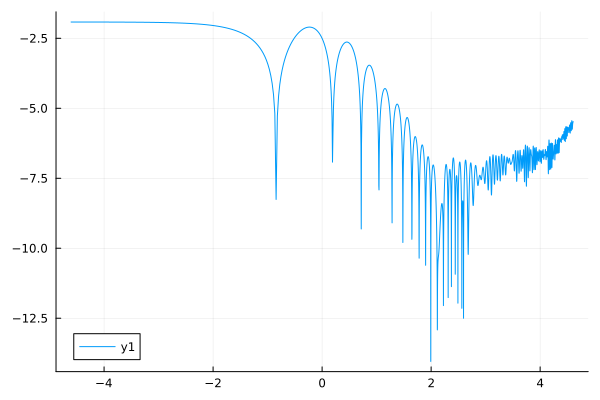

In [22]:
plot(log.(times), log.(abs.(results)))

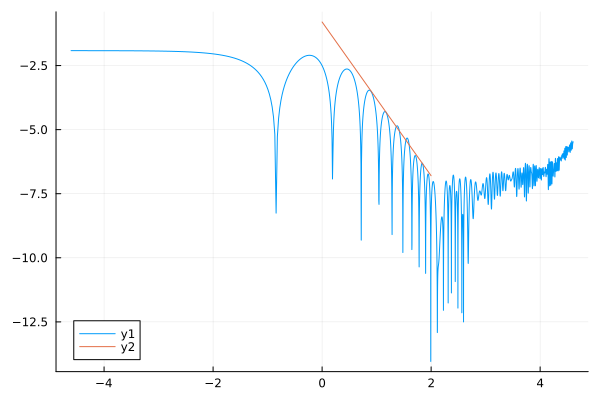

In [23]:
mask = (log.(times) .>= 0) .& (log.(times) .<= 2)
filtered_times = times[mask]
plot!(log.(filtered_times), log.(filtered_times.^-3).- 0.8) #t^-3 power law

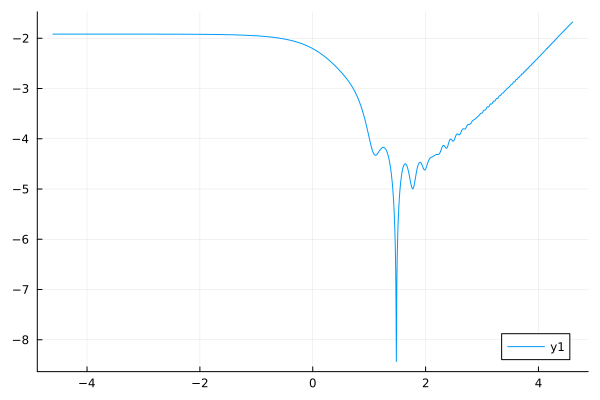

In [10]:
plot(log.(times), log.(test_results))

In [9]:
using DataFrames, CSV
df = DataFrame(time = times, result = results)
CSV.write("data/ising_075_1.csv", df)

"data/ising_075_1.csv"